In [18]:
%matplotlib widget

In [19]:
import xtrack as xt
import matplotlib.pyplot as plt

### Load LHC model from acc-models-lhc

In [20]:
lhc = xt.Multiline.from_json('../../acc-models-lhc/xsuite/lhc.json')


Loading line from dict:   0%|          | 0/14477 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/14493 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particles

In [21]:
particle_ref = xt.Particles(energy0=6.8e12, mass0=xt.PROTON_MASS_EV)
lhc.b1.particle_ref = particle_ref
lhc.b2.particle_ref = particle_ref

### Cycle starting point to IP7

In [22]:
lhc.b1.cycle('ip7')
lhc.b2.cycle('ip7')

<Line  at 14204069520>

### Twiss default for B2 (use clockwise ref. frame)

In [23]:
lhc.b2.twiss_default['reverse'] = True

### Load optics

In [24]:
lhc.vars.load_madx(
    "../../acc-models-lhc/strengths/ATS_Nominal/2024/ats_30cm.madx")

### Switch off all orbit bumps

In [25]:
lhc['on_disp'] = 0.
lhc['on_xx1_v'] = 0.
lhc['on_x1_v'] = 0.
lhc['on_sep1_h'] = 0.
lhc['on_sep2h'] = 0.
lhc['on_x2v'] = 0.
lhc['on_xx5_h'] = 0.
lhc['on_x5_h'] = 0.
lhc['on_sep5_v'] = 0.
lhc['on_sep8h'] = 0.
lhc['on_x8v'] = 0.

### Twiss

In [26]:
twb1 = lhc.b1.twiss4d()
twb2 = lhc.b2.twiss4d()

In [27]:
twb1.rows['ip.*'].cols['s betx bety']

TwissTable: 9 rows, 4 cols
name               s          betx          bety
ip7                0       120.813        149.43
ip8          3321.22             2             2
ip1.l1       6664.72           0.3           0.3
ip1          6664.72           0.3           0.3
ip2          9997.16            10            10
ip3          13329.4       121.567       218.585
ip4          16661.7       239.414       242.774
ip5            19994           0.3           0.3
ip6          23326.4       188.438       173.703

In [28]:
twb2.rows['ip.*'].cols['s betx bety']

TwissTable: 9 rows, 4 cols
name               s          betx          bety
ip8          3321.06             2             2
ip1.l1       6664.72           0.3           0.3
ip1          6664.72           0.3           0.3
ip2          9997.01            10            10
ip3          13329.4       121.567       218.584
ip4          16661.9       231.105       303.949
ip5          19994.3           0.3           0.3
ip6          23326.6       189.334       175.476
ip7          26658.9       120.813        149.43

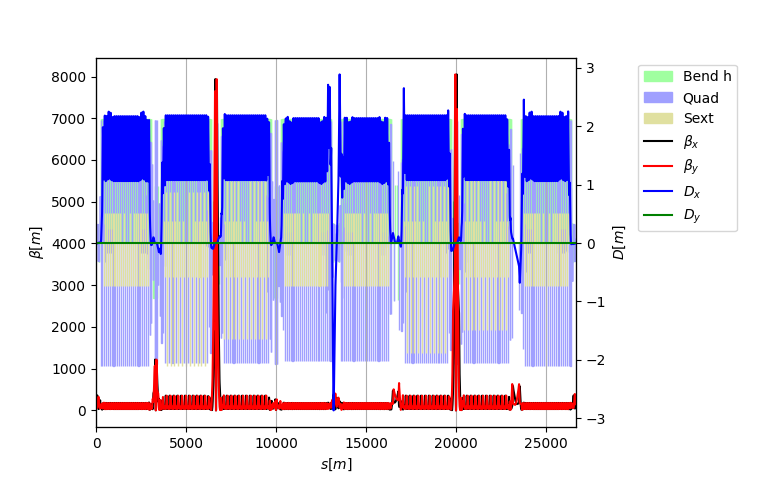

In [29]:
twb2.plot()

### Setup orbit bumps

In [30]:
lhc['on_disp'] = 1.
lhc['on_xx1_v'] = 160.0
lhc['on_x1_v'] = 160.0
lhc['on_sep1_h'] = 0.
lhc['on_sep2h'] = 5 #-1.0
lhc['on_x2v'] = 200.0
lhc['on_xx5_h'] = 160.0
lhc['on_x5_h'] = 160.0
lhc['on_sep5_v'] = 0.
lhc['on_sep8h'] = 5 # -1.0
lhc['on_x8v'] = 200.0

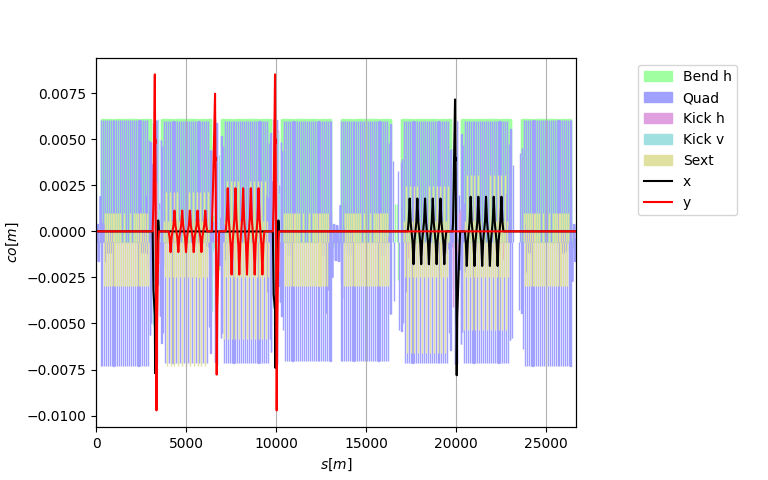

In [31]:
lhc.b2.twiss().plot('x y')

### Inspect circuits

In [34]:
lhc.info('kqx.l5', limit=None)

#  vars['kqx.l5']._get_value()
   vars['kqx.l5'] = -0.00877783444912

#  vars['kqx.l5']._expr is None

#  vars['kqx.l5']._find_dependant_targets()
   vars['kqx.r5']
   eref['b2']['mqxb.b2r5'].k1
   eref['b2']['mqxb.a2r5'].k1
   eref['b2']['mqxa.3r5'].k1
   eref['b2']['mqxa.1r5'].k1
   eref['b1']['mqxb.a2r5'].k1
   eref['b1']['mqxb.b2r5'].k1
   eref['b1']['mqxa.3r5'].k1
   eref['b1']['mqxa.1r5'].k1
   eref['b2']['mqxb.a2l5'].k1
   eref['b2']['mqxb.b2l5'].k1
   eref['b2']['mqxa.3l5'].k1
   eref['b2']['mqxa.1l5'].k1
   eref['b1']['mqxb.a2l5'].k1
   eref['b1']['mqxb.b2l5'].k1
   eref['b1']['mqxa.3l5'].k1
   eref['b1']['mqxa.1l5'].k1



In [33]:
tt = lhc.b1['mqxb.a2r5'].get_info()

Element of type:  Quadrupole
k1                  -0.0087653179066814  (1.0 * ((-vars['kqx.r5']) - vars['ktqx2.r5']))
k1s                 0.0                  None                                          
length              5.5                  vars['l.mqxb']                                
num_multipole_kicks 0                    None                                          
order               5                    None                                          
inv_factorial_order 0.008333333333333333 None                                          
knl                 [0. 0. 0. 0. 0. 0.]  None                                          
ksl                 [0. 0. 0. 0. 0. 0.]  None                                          
edge_entry_active   0                    None                                          
edge_exit_active    0                    None                                          
_sin_rot_s          -999.0               None                                          
_co

### Match a knob to move b2 horizontally in IP1

In [35]:
opt_b2 = lhc.b2.match_knob(
            run=False,
            knob_name='shift_h_ip1.b2',
            start='e.ds.l1.b2', end='s.ds.r1.b2',
            betx=1, bety=1, x=0, y=0, px=0, py=0, # <- initial conditions
            vary=xt.VaryList(['acbyh4.r1b2', 'acbch6.r1b2',
                              'acbyhs4.l1b2', 'acbch5.l1b2'],
                              step=1e-6),
            targets=[
                xt.TargetSet(x=1e-3, px=0, at='ip1'),
                xt.TargetSet(x=0, px=0, at=xt.END),
            ])
opt_b2.solve()
opt_b2.generate_knob()

                                             
Optimize - start penalty: 0.01          
Matching: model call n. 7               
Optimize - end penalty:  3.14737e-09
Generated knob:  shift_h_ip1.b2


## Test the knob

In [36]:
lhc['shift_h_ip1.b2'] = -2
lhc.b2.twiss4d()['x', 'ip1']

-0.001999999219801637

In [37]:
lhc['shift_h_ip1.b2'] = 3
lhc.b2.twiss4d()['x', 'ip1']

0.0030000008212039807

### Visualize orbit bump within the machine aperture

In [38]:
%%capture
from lhc_aperture_model import LhcApertureModel
aper_model = LhcApertureModel(lhc=lhc,
                aperture_file_path='APERTURE_EYETS 2023-2024.seq')

In [39]:
# Try to shift by 8 mm:
lhc['shift_h_ip1.b2'] = 8

Start twiss
Done twiss


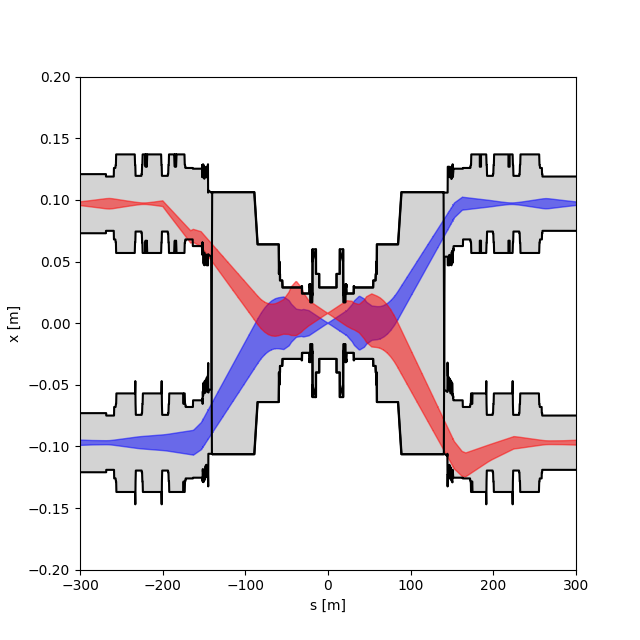

In [40]:
plt.figure(figsize=(6.4, 6.4))
aper_model.plot_horizontal_aperture_and_beam_envelopes(zero_at='ip1')
plt.xlim(-300, 300)
plt.ylim(-0.20, 0.20)
plt.show()

In [ ]:
# Try a smaller shift (4 mm)
lhc['shift_h_ip1.b2'] = 4

In [ ]:
plt.figure(figsize=(6.4, 6.4))
aper_model.plot_horizontal_aperture_and_beam_envelopes(zero_at='ip1')
plt.xlim(-300, 300)
plt.ylim(-0.20, 0.20)
plt.show()